<a href="https://colab.research.google.com/github/coraldx5/generativeai_intro_book/blob/master/chap07_mnist_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第7章：画像分類問題を解いてみよう
- 手書きの数字を1~9に分類するモデルを作成します

- 本Notebookのゴール感
  - コードを動かしながら画像解析に対する理解を深める

## GPUが使用可能であることを確認
- 手動で設定する場合には「ランタイム」メニュー→「ランタイムのタイプを変更」→「ハードウェア アクセラレータ」をGPU（T4 GPU、など）に設定→「保存」ボタンを押下

In [1]:
!nvidia-smi  # ←GPUが使用可能であることを確認

Tue Jul  9 16:32:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ライブラリのインポート

In [1]:
# TensorFlowライブラリをtfという別名でインポートします
import tensorflow as tf

# Kerasのインポート
import keras
from keras import layers
from keras import initializers

# ネットワーク（モデル）を構築するための「部品」をインポートします
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense

# モデルの構造を可視化するためのライブラリをインポートします
from tensorflow.keras.utils import plot_model

# グラフや画像を描画するためのライブラリをインポートします
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np

## 学習に使うデータの準備

### データの準備（[MNISTデータ](https://ja.wikipedia.org/wiki/MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9)のダウンロード）


- tf.keras.datasets.~を使うことで、[すでに公開されているデータセット](https://keras.io/api/datasets/)を取得することが可能です

- 今回用いる数字データセット（MNIST digits classification dataset）の詳細は[こちら](https://keras.io/api/datasets/mnist/)  

11490434/11490434 [==============================] - 2s 0us/step
学習用画像の形状:  (60000, 28, 28)
学習用ラベルの形状:  (60000,)
検証用画像の形状:  (10000, 28, 28)
検証用ラベルの形状:  (10000,)


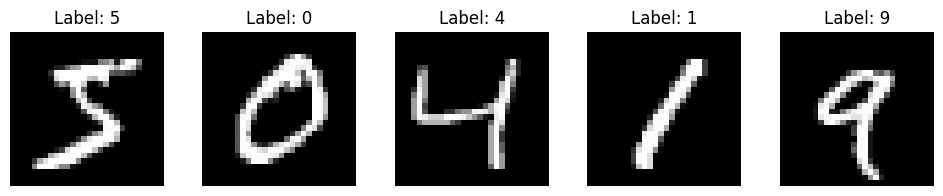

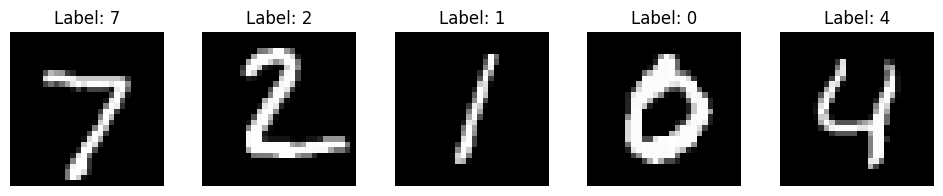

In [2]:
# MNISTデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# データの正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

# データの確認
print("学習用画像の形状: ", x_train.shape)
print("学習用ラベルの形状: ", y_train.shape)
print("検証用画像の形状: ", x_test.shape)
print("検証用ラベルの形状: ", y_test.shape)

# データの可視化
def plot_sample_images(images, labels, num_samples):
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 学習用データから5個のサンプルを表示
plot_sample_images(x_train, y_train, num_samples=5)
# 検証用データから5個のサンプルを表示
plot_sample_images(x_test, y_test, num_samples=5)

## 関数の定義

In [3]:
'''
参考：このコードセルの内容を理解する必要はありません
'''
# 学習曲線を描画する関数
def plot_learning_curve(history):
    # 学習用データと検証用データの正解率を取得
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # 学習用データと検証用データの損失を取得
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # エポック数の範囲を設定
    epochs = range(1, len(acc) + 1)

    # 正解率をプロット
    plt.figure(figsize=(12, 4))  # グラフのサイズを設定
    plt.subplot(1, 2, 1)  # 2つのサブプロットのうち1つ目
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')  # 学習用データの正解率をプロット
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')  # 検証用データの正解率をプロット
    plt.title('Training and validation accuracy')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Accuracy')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    # 損失をプロット
    plt.subplot(1, 2, 2)  # 2つのサブプロットのうち2つ目
    plt.plot(epochs, loss, 'bo-', label='Training loss')  # 学習用データの損失をプロット
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # 検証用データ損失をプロット
    plt.title('Training and validation loss')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Loss')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    plt.show()  # グラフを表示

## もっとも単純なモデルを作ってみよう

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


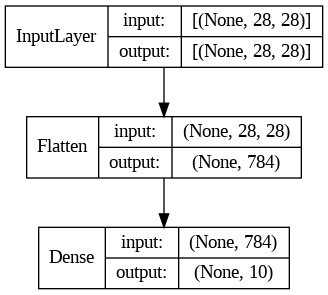

In [4]:
# モデルの定義
model01 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(10, activation='softmax')
], name='model01')

# モデルのサマリーを表示
model01.summary()

# モデルを可視化して画像を出力
plot_model(model01, to_file='model01.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model01.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 8s 3ms/step - loss: 0.4693 - accuracy: 0.8770 - val_loss: 0.3068 - val_accuracy: 0.9156
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3032 - accuracy: 0.9151 - val_loss: 0.2831 - val_accuracy: 0.9216
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2829 - accuracy: 0.9216 - val_loss: 0.2744 - val_accuracy: 0.9231
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2728 - accuracy: 0.9243 - val_loss: 0.2700 - val_accuracy: 0.9254
Epoch 5/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2669 - accuracy: 0.9252 - val_loss: 0.2660 - val_accuracy: 0.9260


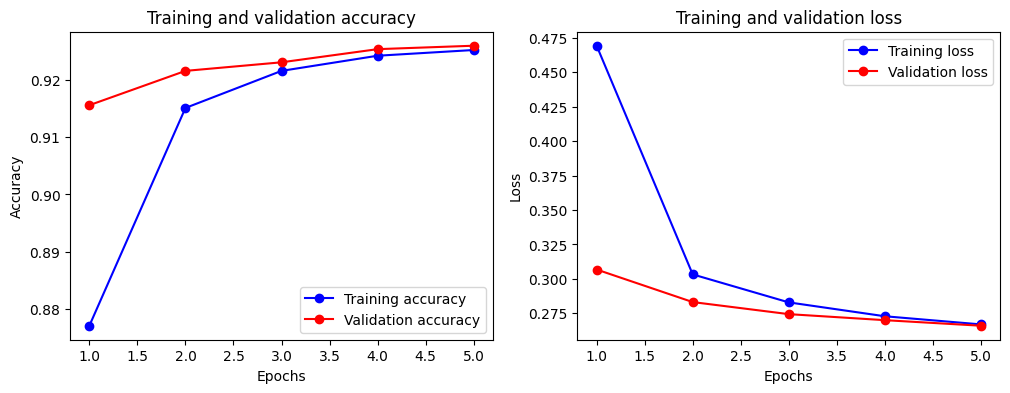

In [5]:
# コンパイルと学習を行う関数を定義
def compile_and_learn(model):
    # 結果の再現性を担保するために乱数シードを固定
    keras.utils.set_random_seed(821)
    tf.config.experimental.enable_op_determinism()
    # モデルをコンパイルする
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # モデルの学習
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)
    # 学習曲線の描画
    plot_learning_curve(history)
    return model

# コンパイルと学習を実行
model01 = compile_and_learn(model01)

In [6]:
# 受け取った学習済みモデルのサマリーを表示
model01.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 隠れ層を1つ追加したモデルを作ってみよう

Model: "hidden_layer01_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               100480    
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


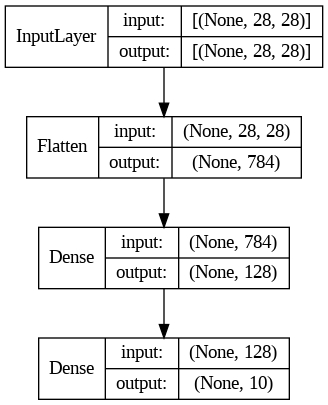

In [21]:
# モデルの定義
model02 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
],name='model02')

# モデルのサマリーを表示
model02.summary()

# モデルを可視化して画像を出力
plot_model(model02, to_file='model02.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model02.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2585 - accuracy: 0.9256 - val_loss: 0.1486 - val_accuracy: 0.9530
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1131 - accuracy: 0.9667 - val_loss: 0.1009 - val_accuracy: 0.9698
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0787 - accuracy: 0.9770 - val_loss: 0.0961 - val_accuracy: 0.9706
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0590 - accuracy: 0.9818 - val_loss: 0.0806 - val_accuracy: 0.9735
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0771 - val_accuracy: 0.9768


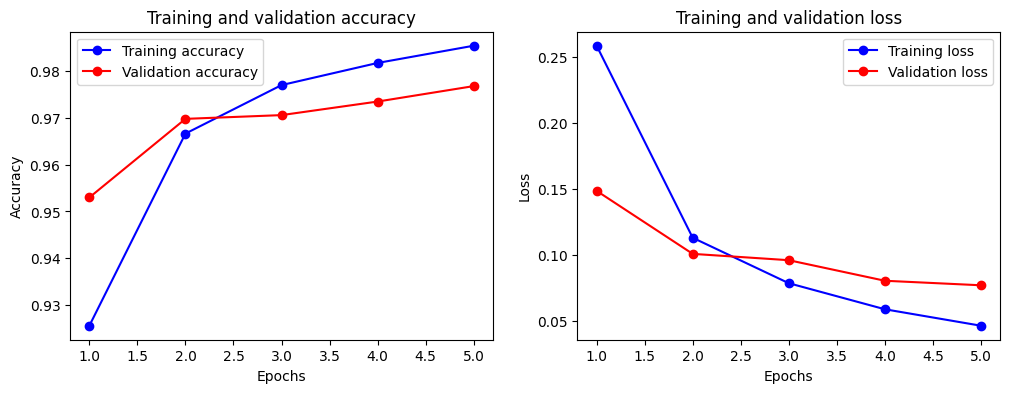

In [22]:
# コンパイルと学習を実行
model02 = compile_and_learn(model02)

## 高度なモデルを作ってみよう

Model: "model03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 6)         30        
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 16)        400       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 576)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               7385

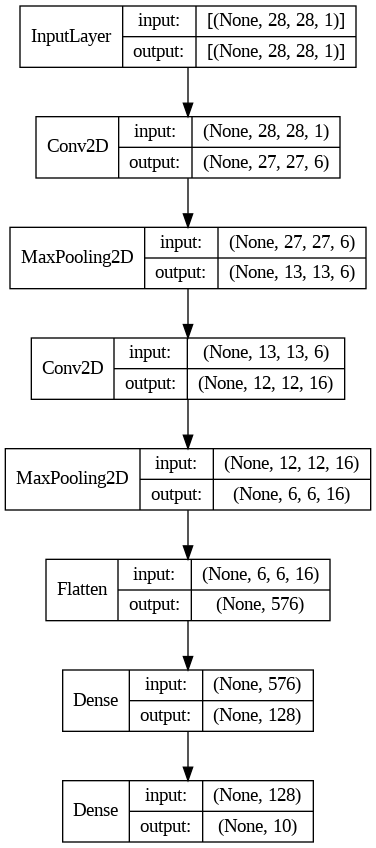

In [23]:
# モデルの定義
model03 = Sequential([
    Conv2D(6, kernel_size=(2, 2), input_shape=(28, 28, 1), activation='ReLU'), #← 第一の畳み込み層
    MaxPooling2D(pool_size=(2, 2)), #← 第一の最大値プーリング層
    Conv2D(16, kernel_size=(2, 2), activation='ReLU'),#← 第二の畳み込み層
    MaxPooling2D(pool_size=(2, 2)),#← 第二の最大値プーリング層
    Flatten(),#← 全結合層
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
],name='model03')

# モデルのサマリーを表示
model03.summary()

# モデルを可視化して画像を出力
plot_model(model03, to_file='model03.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='model03.png'))

### モデルのコンパイルと学習

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2145 - accuracy: 0.9365 - val_loss: 0.0863 - val_accuracy: 0.9722
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0713 - accuracy: 0.9776 - val_loss: 0.0581 - val_accuracy: 0.9811
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0502 - accuracy: 0.9842 - val_loss: 0.0550 - val_accuracy: 0.9828
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0381 - accuracy: 0.9879 - val_loss: 0.0392 - val_accuracy: 0.9873
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.0400 - val_accuracy: 0.9875


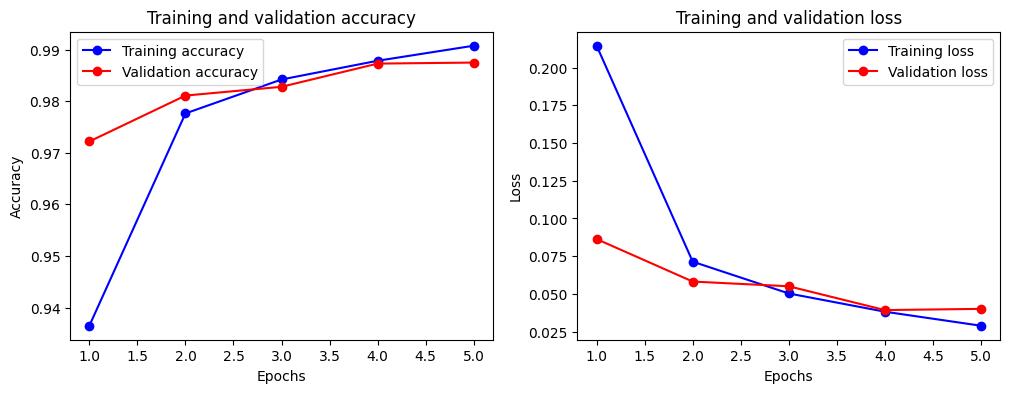

In [18]:
# コンパイルと学習を実行
model03 = compile_and_learn(model03)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 26.2 MB/s eta 0:00:00


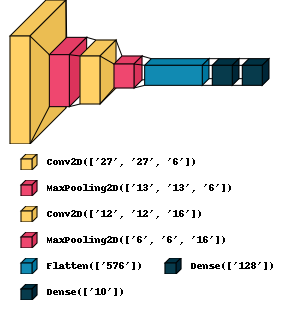

In [11]:
# @title ## 参考：モデルの可視化を行うコード
# ネットワーク構造を可視化するためのライブラリをインストールします
!pip install visualkeras==0.1.0
import visualkeras

# 立体的に可視化してみよう
model_name = "model03" # @param ["model01", "model02", "model03"]
if model_name=="model01":
    md=model01
elif model_name=="model02":
    md=model02
elif model_name=="model03":
    md=model03
visualkeras.layered_view(md, legend=True, show_dimension=True)

## 参考：GUIを作ってみよう

In [12]:
!pip install gradio==4.29.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.7 MB

In [14]:
# @title ## 参考：GUIで手書き文字を認識しよう
import gradio as gr
import numpy as np

model_name = "model01"  # @param ["model01", "model02", "model03"]
if model_name == "model01":
    md = model01
elif model_name == "model02":
    md = model02
elif model_name == "model03":
    md = model03

# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0  # Normalize the image to range [0, 1]
    return normalized_image

# Define the prediction function
def classify(sketch):
    image = sketch["composite"]
    grayscale_image = np.mean(image, axis=2)  # Average across RGB channels

    # Resize and normalize the image
    resized_image = reshape_to_28x28(grayscale_image)

    # Convert the image to the correct shape for the model
    reshaped_image = resized_image.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

    # Make predictions and convert the result to a list
    pred = md.predict(reshaped_image).tolist()[0]

    # Get the top 3 predictions
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # Store confidences in a dictionary
    confidences = {str(i): v for i, v in zip(indices, values)}

    return confidences

# Gradioインターフェースを作成
gr.Interface(
    fn=classify,
    inputs="sketchpad",
    outputs="label",
).launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5201e549e0f7b0c508.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 47ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5201e549e0f7b0c508.gradio.live


In [ ]:
# Function to resize and normalize the image
def reshape_to_28x28(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    resized_image = tf.image.resize(image, [28, 28]).numpy()
    normalized_image = resized_image / 255.0  # Normalize the image to range [0, 1]
    return normalized_image

# Define the prediction function
def classify(sketch):
    image = sketch["composite"]
    grayscale_image = np.mean(image, axis=2)  # Average across RGB channels

    # Resize and normalize the image
    resized_image = reshape_to_28x28(grayscale_image)

    # Convert the image to the correct shape for the model
    reshaped_image = resized_image.reshape(1, 28, 28, 1)  # Add batch and channel dimensions

    # Make predictions and convert the result to a list
    pred = model.predict(reshaped_image).tolist()[0]

    # Get the top 3 predictions
    values, indices = tf.math.top_k(pred, k=3)
    values = values.numpy().tolist()
    indices = indices.numpy().tolist()

    # Store confidences in a dictionary
    confidences = {str(i): v for i, v in zip(indices, values)}

    return confidences

# Gradioインターフェースを作成
gr.Interface(
    fn=classify,
    inputs="sketchpad",
    outputs="label",
).launch(debug=True)


Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c623cd89bd7fa7aba6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 24ms/step


# CNNネットワークの定義

## LeNet-5っぽいネットワークを定義してみる
[LeNet の構造](https://cvml-expertguide.net/terms/dl/cnn-backbone/lenet/)
- Lenet-5は、1998年にYann LeCunらがGradient-Based Learning Applied to Document Recognitionという研究論文で提案した、最も初期のモデルの1つ。
  - [畳み込み – 活性化関数 – プーリング層]の繰り返しにより、LeNetの前半が構成されている。
    - 畳み込み：特徴量を抽出するイメージ
    - 活性化層：活性化関数（ReLu、tanh、step、sigmoid、等）により、特徴量をフィルタリングするイメージ
    - プーリング層：解像度を下げてボカすイメージ
    - <img src="https://betashort-lab.com/wp-content/uploads/2018/07/1523891796216.jpg"  width="600" alt="サンプル画像" align="top" >
    - 参考：[An intuitive guide to Convolutional Neural Networks](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)
    - <img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-ja.jpeg?69ac778e9cc7f76daa731a16801b4232"  width="600" alt="サンプル画像" align="top" >
    - 参考：[畳み込みニューラルネットワーク チートシート](https://stanford.edu/~shervine/l/ja/teaching/cs-230/cheatsheet-convolutional-neural-networks)
- 参考：[ConvNet計算機1](https://zimonitrome.github.io/convolution-shape-calculator/)
- 参考：[ConvNet計算機2](https://madebyollin.github.io/convnet-calculator/)
<br>
<br>
- Lenet-5は、次のような層構成である。
    - 最初の層は入力層で、特徴マップのサイズは32X32X1である。（今回のデータセットでは28x28x1）
    - 次の層は、サイズ5X5、ストライド1の6つのフィルタを持つ第1畳み込み層（この層で使用される活性化関数は、tanh）（今回はデータセットに合わせてカーネルサイズは1x1）
    - 次の層は、フィルターサイズ2X2、ストライド1のプーリング層
    - 次の層は、5X5、ストライド1の16個のフィルタを持つ第2番目畳み込み層（この層で使用される活性化関数は、tanh）
    - 次の層は、2X2、ストライド2のプーリング層
    - 次の層は、プーリング層は、5X5、ストライド1、活性化関数tanhの120個のフィルターであり、これで出力サイズは120となる。
    - 平滑化層：上記の層の出力結果を全て結合する（Fully Connected、線形層(Linear layer)や、密接続層(dense connection layer)とも）
    - 次の層は、84個のニューロンを持つ完全接続層で、出力は84値になり、ここで使用される活性化関数は再びtanhである。
    - 最後の層は出力層で、10個のニューロンを持ち、Softmax関数が使用されている。
<br>
<br>
- 以上が、Lenet-5モデルの全アーキテクチャであり、このアーキテクチャの学習可能なパラメータの数は、およそ6万個である。

In [ ]:
# LeNet-5っぽいネットワークを定義してみる
class LeNet5(nn.Module):
    # ニューラルネットワーク層を初期化する
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        # ここからネットワーク定義
        # 特徴量を取り出すfeaturesを定義
        self.features = nn.Sequential(
            # inputチャンネル数:1、outputチャンネル数:6、カーネルサイズ5の畳み込み
            nn.Conv2d(1, 6, kernel_size=1, stride=1),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # カーネルサイズ2のAveragePooling
            nn.AvgPool2d(kernel_size=2, stride=2),
            # inputチャンネル数:1、outputチャンネル数:16、カーネルサイズ5の畳み込み
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # カーネルサイズ2のAveragePooling
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # 分類結果を出力するclassifierを定義
        self.classifier = nn.Sequential(
            # 400個の長さの配列を120個に線形変換
            nn.Linear(400, 120),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # 120個の長さの配列を84個に線形変換
            nn.Linear(120, 84),
            # 活性化関数としてtanh（ハイパボリックタンジェント）
            nn.Tanh(),
            # 120個の長さの配列を10個に線形変換
            nn.Linear(84, 10)
        )

    # forwardにて、実際の入力データを演算する
    def forward(self, x):
        # 特徴量を取り出すfeaturesを呼び出し
        x = self.features(x)
        # 16*5*5の次元を、400の連続的な配列に変換する
        x = torch.flatten(x,1)
        # 分類結果を出力するclassifierを呼び出し
        logit = self.classifier(x)
        return logit

In [ ]:
net = LeNet5()
print(net)

In [ ]:
# ネットワーク可視化（縦×横が28×28のチャンネル1の画像を1枚入れたときの挙動を確認）
summary(net, (1, 1, 28, 28))

In [ ]:
# 指定したdevice（CPUもしくはGPU）にネットワークを転送
net = net.to(device)

## 損失関数および最適化関数の定義
---

In [ ]:
#学習するための関数を定義
def learn_network(net,epc=3):
    # 交差エントロピー誤差関数
    loss_func = nn.CrossEntropyLoss()
    # 今回はAdam(移動平均計算や学習率の調整により振動を抑制させる手法)を利用
    optimizer = optim.Adam(net.parameters())

    train_loss_track = []
    test_loss_track = []
    # エポックは今回「3」で設定
    for epoch in range(epc):
        running_loss = 0
        running_train_loss = 0
        running_test_loss = 0

        # 学習モード
        net.train()
        for batch_idx, (xx, yy)  in enumerate(train_loader):
            xx = xx.to(device)
            yy = yy.to(device)
            optimizer.zero_grad()
            y_pred = net(xx)
            loss = loss_func(y_pred, yy)
            loss.backward()
            optimizer.step()
            # 学習データを使って損失を計算
            running_loss += loss.item()
            running_train_loss += loss.item()
            if (batch_idx+1) % 100 == 0:
                print('[', epoch+1, ',',batch_idx+1, ']','loss: ', running_loss / 100)
                running_loss = 0.0
        # エポックが終了したら平均損失を計算
        train_loss_track.append(running_train_loss / (batch_idx + 1))

        # 評価（evaluation）モード ※詳細は後述
        net.eval()
        with torch.no_grad():  # 誤差逆伝播法を使った傾きの計算を無効にする設定で、メモリ消費量を削減できるメリットがある（推論時はパラメータの更新をしないため）
            for batch_idx, (xx_test, yy_test)  in enumerate(test_loader):
                xx_test = xx_test.to(device)
                yy_test = yy_test.to(device)
                # 予測値を計算
                y_pred = net(xx_test)
                # 誤差関数を使ってギャップの計測
                test_loss = loss_func(y_pred, yy_test)
                # テストデータを使って損失を計算
                running_test_loss += test_loss.item()
            # 誤差をトラッキング
            test_loss_track.append(running_test_loss / (batch_idx + 1))

    return net, train_loss_track


# 正解率を計算し・混同行列を可視化する関数
def calc_accuracy_and_show_cm(net):
    true = 0
    total = 0

    all_labels = np.array([])
    all_preds = np.array([])
    with torch.no_grad():
        for test_xx, test_yy in test_loader:
            # device = "cuda"の場合、GPUにデータを転送する
            test_xx = test_xx.to(device)
            test_yy = test_yy.to(device)
            outputs = net(test_xx)
            # torch.max()の出力は2つですが、1つ目の値は利用しないため、それを明示するために変数「_」を利用
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
            all_preds = np.append(all_preds, predicted.cpu().numpy())
            total += test_yy.size(0)
            true += (predicted == test_yy).sum().item()
    print('Accuracy: ', 100 * float(true/total), '%')

    print('\nConfusion Matrix:')
    labels = np.unique(all_labels)
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    display(pd.DataFrame(cm, columns=labels, index=labels))

    return all_labels, all_preds

# モデル学習と精度評価

## 学習  
フィードフォワード計算 → アウトプットと正解ラベルとの誤差計算 → 誤差逆伝搬法を使って自動微分 → パラメータ（重みなど）更新、を繰り返して学習させる

In [ ]:
net, train_loss_track = learn_network(net)

### 誤差の推移

In [ ]:
plt.plot(train_loss_track)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## テストデータにおける精度評価

- Accuracyを計算  
  - Accuracyとは全体のデータ数に対して予測と正解のラベルが一致した数の割合
- 混同行列（Confusion Matrxi）を可視化

In [ ]:
all_labels, all_preds = calc_accuracy_and_show_cm(net)

### 誤認識した画像の確認

In [ ]:
# 間違った画像のindex
np.where(all_labels != all_preds)

In [ ]:
# 間違った画像のindexから1つ確認
i = 0
idx = np.where(all_labels != all_preds)[0][i]
plt.imshow(testset.data[idx], cmap='gray')
print("Label : ", all_labels[idx])
print("Pred  : ", all_preds[idx])